Quantum computing offers significant speedups for certain problems, with Quantum Support Vector Machines (QSVMs) emerging as a promising quantum-enhanced machine learning technique.

### 1. Background on SVMs

**SVM Objective:**

The goal of a Support Vector Machine (SVM) is to find a hyperplane that best separates data into different classes. Mathematically, we aim to maximize the margin between the two classes.

**Mathematical Formulation:**

In the original feature space, the decision boundary is given by:

$$
f(x) = w \cdot x + b
$$

where $w$ is the weight vector and $b$ is the bias term. The SVM optimization problem can be described as:

$$
\text{minimize } \frac{1}{2} \|w\|^2
$$

subject to:

$$
y_i (w \cdot x_i + b) \geq 1 \text{ for all } i
$$

### 2. The Kernel Trick

**Kernel Function:**

 If the classes are not linearly separable, the SVM can utilize kernel trick to map the non-linearly separable data into a higher-dimensional space, enabling linear classifiers to effectively classify complex datasets, This method leverages kernels or inner products of feature vectors for the transformation:

$$
K(x_i, x_j) = \phi(x_i) \cdot \phi(x_j)
$$

Kernel-based SVMs leverage kernel functions to project data into higher-dimensional spaces where linear separation is feasible (shown as the figure below), thus effectively handling complex, non-linear patterns without direct high-dimensional computations.

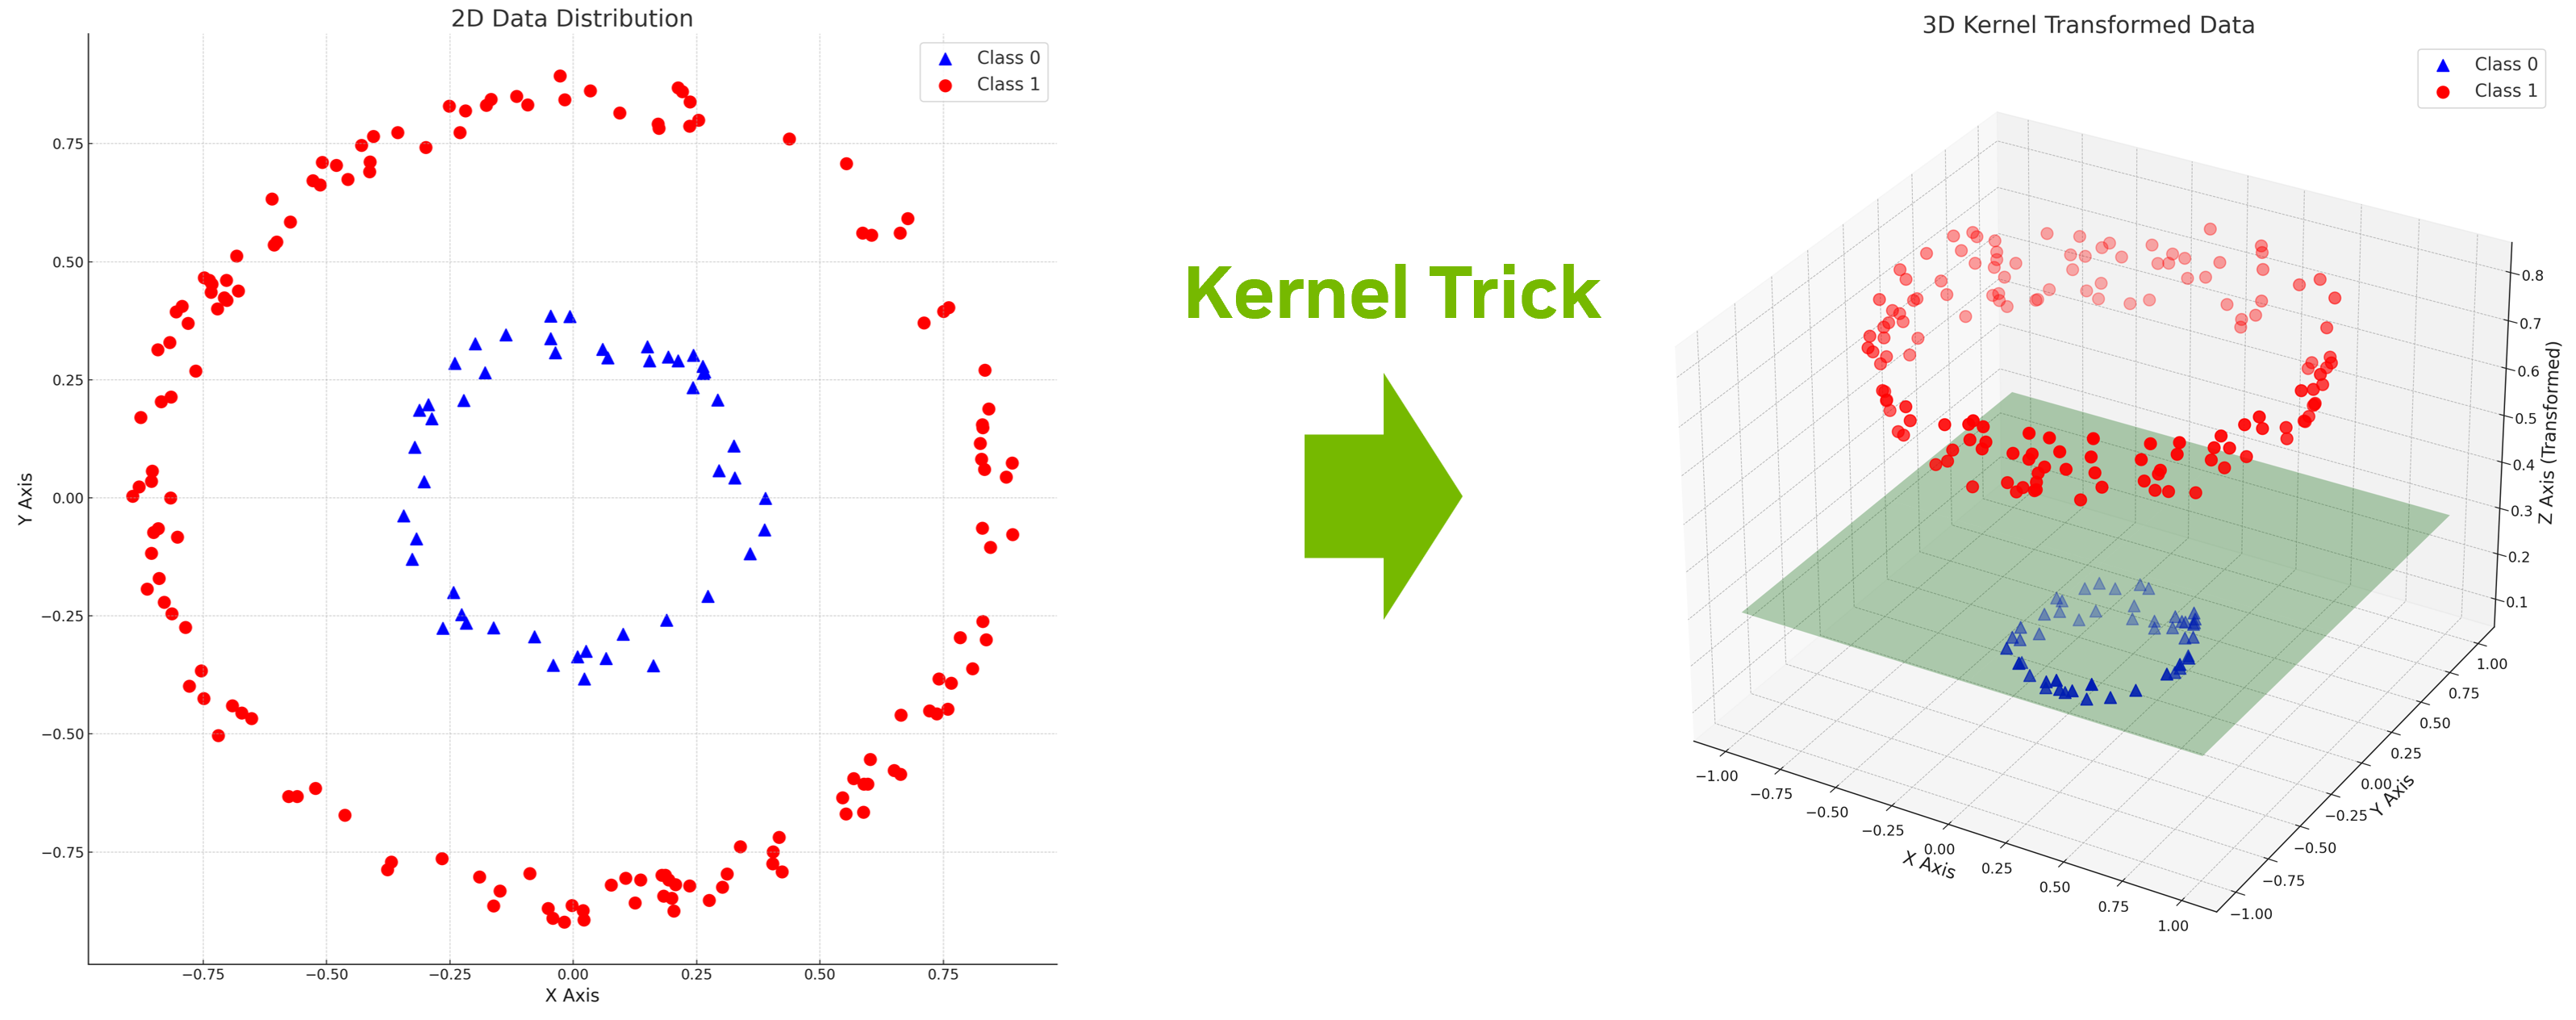

### 3. QSVM (Quantum Support Vector Machine)

**Quantum Kernel:**

In QSVMs, the measurement of a quantum circuit calculates the inner product in a high-dimensional space that is accessible through quantum gates, without the need for explicit transformation, The quantum kernel function can be represented as:

$$
K(x_i, x_j) = \langle \phi(x_i) | \phi(x_j) \rangle
$$


where the quantum states $|\phi(x)\rangle$ encode the features of the data $x$. These states can be prepared by applying a sequence of unitary gates $|U(x)\rangle$ to an initial quantum state. In this example, we use Block-Encoded State (BPS) wavefunctions as our quantum data encoding:



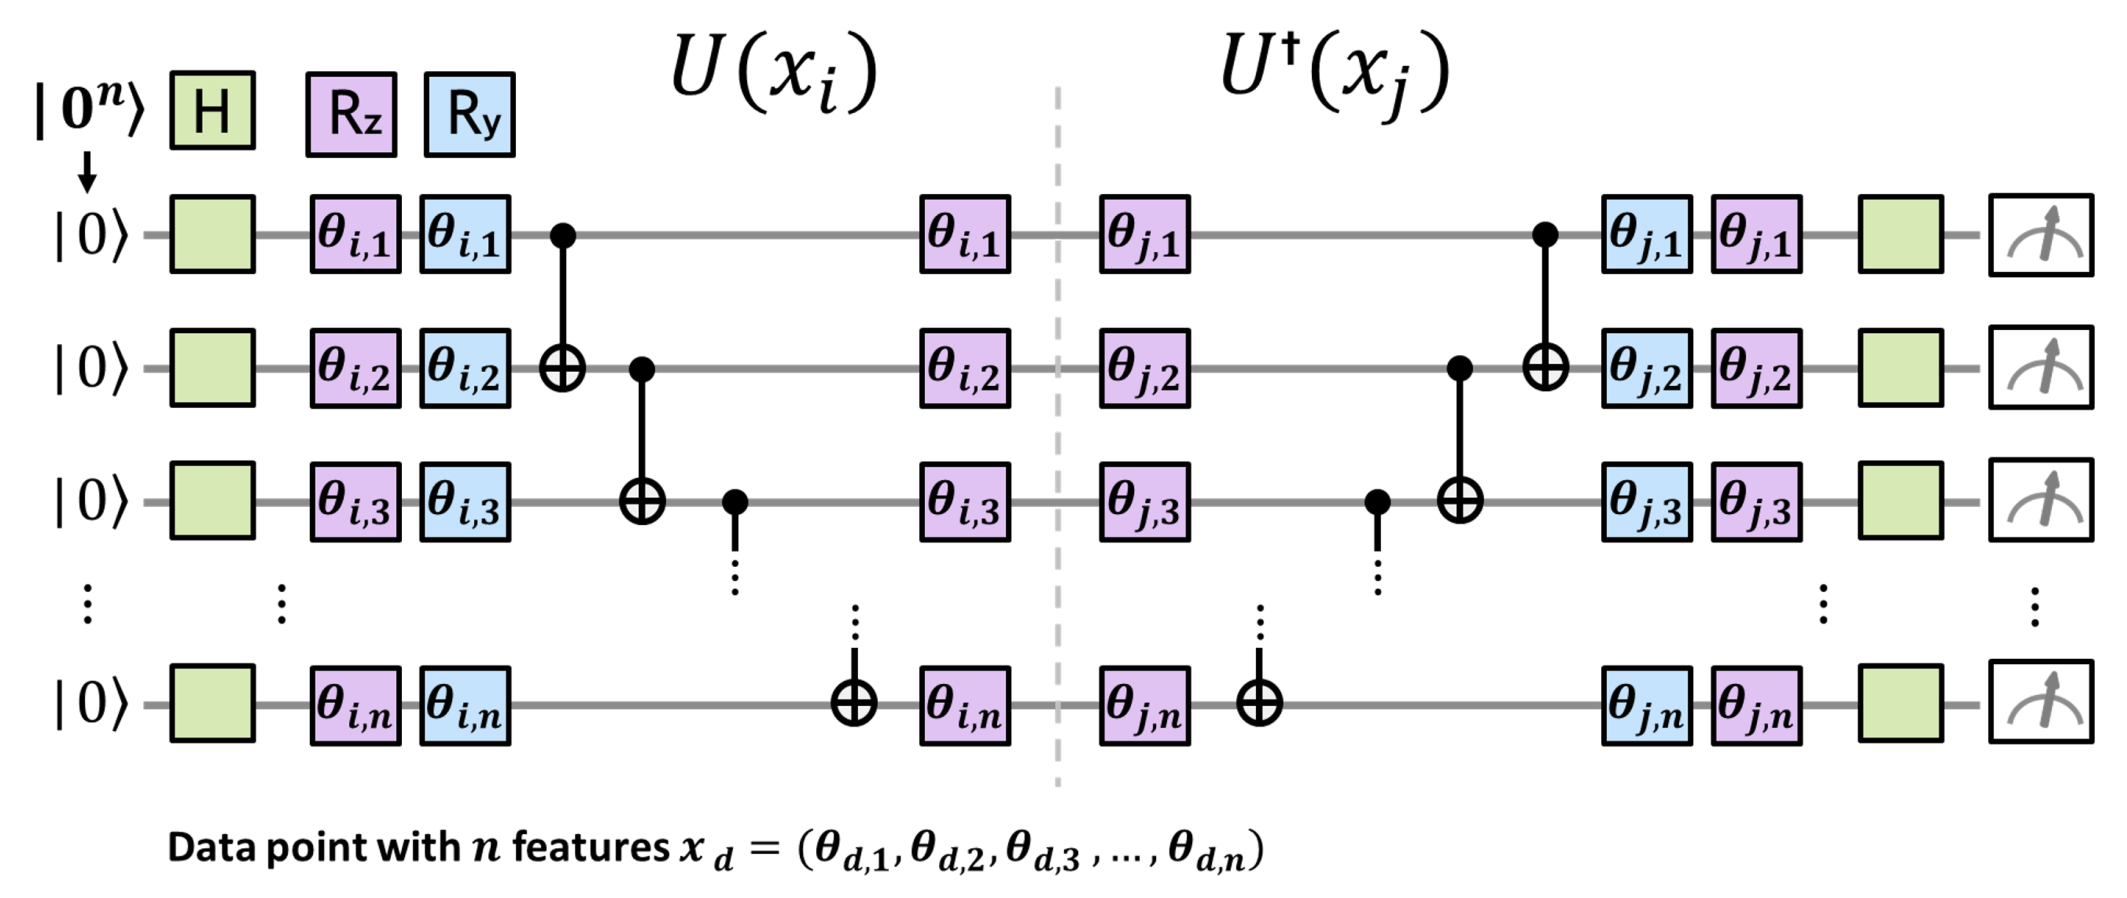

### 4. Workflow of QSVM

1. **Prepare Quantum Data:**
Encode data into quantum states using a quantum data encoding scheme.

2. **Compute Quantum Kernel:**
Use a quantum circuit to compute the kernel function between data points, formulating the quantum kernel matrix.

3. **Train the QSVM:**
The kernel matrix is then applied to train
a support vector classifier (SVC) to separate complex data.

For more tchnical details, refer to this [publication](https://arxiv.org/abs/2405.02630) to learn how QSVM is accelerated by [NVIDIA Quantum](https://www.nvidia.com/en-us/solutions/quantum-computing/).

Below, we build a CUDA-Q frontend for QSVM implementation with cuQuantum, realizing end-to-end acceleration:

In [ ]:
# # Install the necessary packages
# !pip install scikit-learn
# !pip install qiskit
# !pip install cuquantum cuquantum-python

In [1]:
# Import the relevant libraries
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from itertools import combinations,product
from multiprocessing import Pool
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import fetch_openml
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from cuquantum import *

In [2]:
def prepare_data(target_digits, sample_count, test_size):
    """Load and prepare the MNIST dataset to be used.
    Args:
        target_digits (list): digits to perform classification of
        sample_count (int): total number of images to be used
        test_size (float): percentage of sample_count to be used as test set, the remainder is the training set

    Returns:
        dataset in train, test format with targets
    """

    mnist = fetch_openml('mnist_784', as_frame=False, parser='liac-arff')
    X = mnist.data
    Y = mnist.target.astype(int)

    # Filter out the target labels.
    idx = np.where((Y == target_digits[0])|(Y == target_digits[1]))
    X,Y = X[idx],Y[idx]

     # Select a subset based on number of datapoints specified by sample_count.
    data, label = X[:sample_count],Y[:sample_count]

    return train_test_split(data, label, test_size = test_size, random_state = 255)

In [3]:
target_digits = [0, 1]  # Target digits to classify.
sample_count = 15  # Total number of images to use.
test_size = 0.3  # Percentage of dataset to be used for testing.

X_train, X_test, Y_train, Y_test =  prepare_data(target_digits, sample_count, test_size)

print('train data shape:',X_train.shape)
print('test  data shape:',X_test.shape)

train data shape: (10, 784)
test  data shape: (5, 784)


In [4]:
def dim_reduction(n_dim, sample_train, sample_test):
    """Dimensionality reduction of input data using the PCA method.
    Args:
        n_dim (int): The target number of dimensions after reduction.
        sample_train (numpy.ndarray): The training data samples.
        sample_test (numpy.ndarray): The testing data samples.

    Returns:
        Tuple[numpy.ndarray, numpy.ndarray]: The transformed training and testing data samples.
    """

    std_scale = StandardScaler().fit(sample_train)
    data = std_scale.transform(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)
    pca = PCA(n_components=n_dim, svd_solver="full").fit(data)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)

    return sample_train, sample_test

In [5]:
n_dim = 3  # Target number of dimensions for PCA, equal to the required qubit count
data_train, data_test  = dim_reduction(n_dim, X_train, X_test)

print('train data shape:',data_train.shape)
print('test  data shape:',data_test.shape)

train data shape: (10, 3)
test  data shape: (5, 3)


In [6]:
# Create quantum circuits for generating Block-Encoded State (BPS) wavefunctions of all data pairs 
def make_bsp(n_dim):
    param = ParameterVector("p",n_dim)
    bsp_qc = QuantumCircuit(n_dim)
    bsp_qc.h(list(range(n_dim)))
    i = 0
    for q in range(n_dim):
        bsp_qc.rz(param.params[q],[q])
        bsp_qc.ry(param.params[q],[q])
    for q in range(n_dim-1):
        bsp_qc.cx(0+i, 1+i)
        i+=1
    for q in range(n_dim):
        bsp_qc.rz(param.params[q],[q])
    return bsp_qc
def build_qsvm_qc(bsp_qc,n_dim,y_t,x_t):
    qc_1 = bsp_qc.assign_parameters(y_t).to_gate()
    qc_2 = bsp_qc.assign_parameters(x_t).inverse().to_gate()
    kernel_qc = QuantumCircuit(n_dim)
    kernel_qc.append(qc_1,list(range(n_dim)))
    kernel_qc.append(qc_2,list(range(n_dim)))
    return kernel_qc

In [7]:
def renew_operand(n_dim,oper_tmp,y_t,x_t):
    oper = oper_tmp.copy()
    n_zg, n_zy_g = [], []
    for d1 in y_t:
        z_g  = np.array([[np.exp(-1j*0.5*d1),0],[0,np.exp(1j*0.5*d1)]])
        n_zg.append(z_g)
        y_g  = np.array([[np.cos(d1/2),-np.sin(d1/2)],[np.sin(d1/2),np.cos(d1/2)]])
        n_zy_g.append(z_g)
        n_zy_g.append(y_g)
    oper[n_dim*2:n_dim*4] = cp.array(n_zy_g)
    oper[n_dim*5-1:n_dim*6-1] = cp.array(n_zg)
    n_zgd, n_zy_gd = [], []
    for d2 in x_t[::-1]:       
        z_gd  = np.array([[np.exp(1j*0.5*d2),0],[0,np.exp(-1j*0.5*d2)]])
        n_zgd.append(z_gd)  
        y_gd  = np.array([[np.cos(d2/2),np.sin(d2/2)],[-np.sin(d2/2),np.cos(d2/2)]])
        n_zy_gd.append(y_gd)
        n_zy_gd.append(z_gd)
    oper[n_dim*6-1:n_dim*7-1] = cp.array(n_zgd)
    oper[n_dim*8-2:n_dim*10-2] = cp.array(n_zy_gd)
    return oper
def data_to_operand(n_dim,operand_tmp,data1,data2,indices_list):
    operand_list = []
    for i1, i2 in indices_list:
        n_op = renew_operand(n_dim,operand_tmp,data1[i1-1],data2[i2-1])
        operand_list.append(n_op) 
    return operand_list

In [8]:
bsp_qc = make_bsp(n_dim)

indices_list_train = list(combinations(range(1, len(data_train) + 1), 2))  # Index pairs list of training data for kernel matrix calculation.
indices_list_test  = list(product(range(1, len(data_test) + 1),range(1, len(data_train) + 1)))  # Index pairs list of testing data for kernel matrix calculation

circuit = build_qsvm_qc(bsp_qc,n_dim, data_train[0], data_train[0])
converter = CircuitToEinsum(circuit, dtype='complex128', backend='cupy')
a = str(0).zfill(n_dim)
exp, oper = converter.amplitude(a)

operand_train = data_to_operand(n_dim,oper,data_train,data_train,indices_list_train)
operand_test  = data_to_operand(n_dim,oper,data_test,data_train,indices_list_test)
print("The total number of the operands:", int(len(operand_train) + len(operand_test)))

The total number of the operands: 95


In [9]:
def kernel_matrix_tnsm(y_t, x_t, exp, opers, indices_list, options, mode=None):
    """
    Calculate the kernel matrix using tensor network contraction accelerated by cuQuantum.

    Args:
        y_t (numpy.ndarray): The first set of input data.
        x_t (numpy.ndarray): The second set of input data.
        exp (str): The tensor network expression.
        opers (list): List of tensors.
        indices_list (list): List of index pairs for kernel matrix calculation.
        options (class): Options specified by cuquantum.NetworkOptions for the tensor network.
        mode (str, optional): If 'train', the function will make the kernel matrix symmetric and add a diagonal of ones.

    Returns:
        np.ndarray: The computed kernel matrix.
    """
    
    kernel_matrix = np.zeros((len(y_t),len(x_t)))
    i, oper = -1, opers[0]
    with Network(exp, *oper, options=options) as tn:
        tn.contract_path()
        for i1, i2 in indices_list:
            i += 1
            tn.reset_operands(*opers[i])
            amp_tn = abs(tn.contract()) ** 2
            kernel_matrix[i1-1][i2-1] = np.round(amp_tn,8)
        tn.free()
    if mode == 'train':
        kernel_matrix = kernel_matrix + kernel_matrix.T+np.diag(np.ones((len(x_t))))
        
    return kernel_matrix

In [10]:
# Define the tensor network contraction details with specified operands, options, path, and info
oper = operand_train[0]
options = NetworkOptions(blocking="auto")
network = Network(exp, *oper,options=options)
path, info = network.contract_path()

# Compute the kernel matrix for training and testing data
tnsm_kernel_matrix_train = kernel_matrix_tnsm(data_train, data_train, exp, operand_train, indices_list_train, options, mode='train')
tnsm_kernel_matrix_test  = kernel_matrix_tnsm(data_test, data_train, exp, operand_test, indices_list_test, options, mode=None)

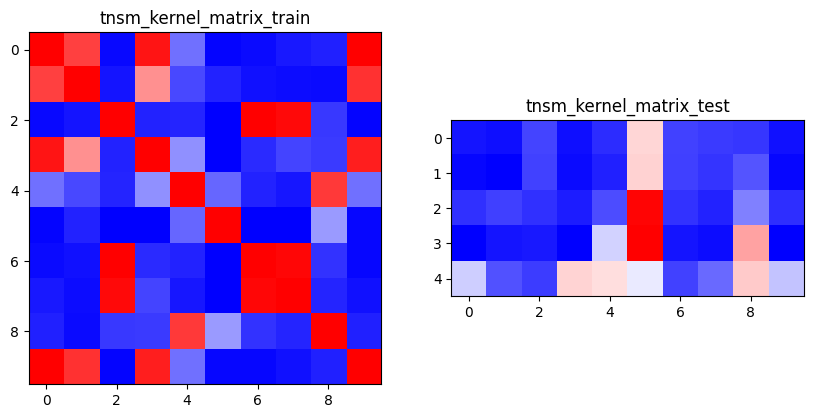

In [11]:
# Visialize the kernel matrix

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(tnsm_kernel_matrix_train), interpolation="nearest", origin="upper", cmap="bwr")
axs[0].set_title("tnsm_kernel_matrix_train")
axs[1].imshow(np.asmatrix(tnsm_kernel_matrix_test), interpolation="nearest", origin="upper", cmap="bwr")
axs[1].set_title("tnsm_kernel_matrix_test")
plt.show()

In [12]:
# Use the precomputed kernel matrix for the subsequent support vector classifier
svc = SVC(kernel="precomputed")
svc.fit(tnsm_kernel_matrix_train,Y_train)
acc_train = svc.score(tnsm_kernel_matrix_train,Y_train)
acc_test = svc.score(tnsm_kernel_matrix_test,Y_test)
print("The training accuracy = ", round(acc_train*100, 3), "(%)")
print("The testing accuracy = ", round(acc_test*100, 3), "(%)")

The training accuracy =  100.0 (%)
The testing accuracy =  80.0 (%)
